In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import zipfile

zip_path="/content/drive/MyDrive/80-20.zip"

with zipfile.ZipFile(zip_path,'r') as zip_ref:
  zip_ref.extractall("/content/drive/MyDrive/dataset80")

In [ ]:
import os
os.listdir("/content/drive/MyDrive/dataset80")

['80-20']

In [ ]:
# Import required libraries
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.utils.class_weight import compute_class_weight
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.applications.densenet import DenseNet201

from tensorflow.keras.applications.densenet import preprocess_input

In [ ]:
train_dir = '/content/drive/MyDrive/dataset80/80-20/train'  # Replace with your actual train path
test_dir = '/content/drive/MyDrive/dataset80/80-20/test'    # Replace with your actual test path
# === STEP 4: Load Class Info ===
class_names = sorted(os.listdir(train_dir))
num_classes = len(class_names)
print("Classes:", class_names)
img_size = (250, 250)
batch_size = 32

Classes: ['Dolphin', 'Fish', 'Jelly Fish', 'Octopus', 'Penguin', 'Sea Rays', 'Sea Urchins', 'Seahorse', 'Sharks', 'Starfish', 'Turtle_Tortoise', 'Whale', 'crab']


In [ ]:
# ImageDataGenerators with DenseNet201 preprocessing
train_gen = ImageDataGenerator(
    preprocessing_function=preprocess_input,
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest'
)

test_gen = ImageDataGenerator(preprocessing_function=preprocess_input)

# Flow from directory
train_data = train_gen.flow_from_directory(
    train_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical'
)

test_data = test_gen.flow_from_directory(
    test_dir,
    target_size=img_size,
    batch_size=batch_size,
    class_mode='categorical',
    shuffle=False
)


Found 4080 images belonging to 13 classes.
Found 1120 images belonging to 13 classes.


In [ ]:
# Compute class weights
class_labels = train_data.classes
class_weights = compute_class_weight(
    class_weight='balanced',
    classes=np.unique(class_labels),
    y=class_labels
)
class_weights = dict(enumerate(class_weights))


In [ ]:
# Load DenseNet201 model
base_model = DenseNet201(input_shape=(250, 250, 3), include_top=False, weights='imagenet')
base_model.trainable = True

# Optional: freeze some layers
for layer in base_model.layers[:-50]:
    layer.trainable = False

# Build model
model = Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dense(128, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.01)),
    Dropout(0.6),
    Dense(num_classes, activation='softmax')
])

74836368/74836368 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


In [ ]:
# Compile model
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=10000,
    decay_rate=0.9
)

optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

model.compile(
    optimizer=optimizer,
    loss='categorical_crossentropy',
    metrics=['accuracy']
)

In [ ]:
# Train model
early_stopping = EarlyStopping(monitor='loss', patience=5, restore_best_weights=True)

history = model.fit(
    train_data,
    epochs=20,
    callbacks=[early_stopping],
    class_weight=class_weights
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 181s 886ms/step - accuracy: 0.2256 - loss: 4.5468
Epoch 2/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 128s 613ms/step - accuracy: 0.6485 - loss: 2.6999
Epoch 3/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 78s 608ms/step - accuracy: 0.7602 - loss: 1.9943
Epoch 4/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 79s 619ms/step - accuracy: 0.8212 - loss: 1.6143
Epoch 5/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 79s 613ms/step - accuracy: 0.8578 - loss: 1.4128
Epoch 6/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 79s 619ms/step - accuracy: 0.8635 - loss: 1.3133
Epoch 7/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 79s 613ms/step - accuracy: 0.8863 - loss: 1.1967
Epoch 8/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 79s 614ms/step - accuracy: 0.9037 - loss: 1.0892
Epoch 9/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 77s 602ms/step - accuracy: 0.9183 - loss: 1.0101
Epoch 10/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 78s 610ms/step - accuracy: 0.9269 - loss: 0.9519
Epoch 11/20
128/128 ━━━━━━━━━━━━━━━━━━━━ 78s 612ms/step - accuracy: 0.9312 - loss: 0.8967
Epoch 12/20
128/1

In [ ]:
# Evaluate model
test_loss, test_accuracy = model.evaluate(test_data)
print(f"\n✅ Final Test Accuracy: {test_accuracy * 100:.2f}% | Test Loss: {test_loss:.4f}")

# Get final training accuracy from history
train_accuracy = history.history['accuracy'][-1]
print(f"✅ Final Training Accuracy: {train_accuracy * 100:.2f}%")


35/35 ━━━━━━━━━━━━━━━━━━━━ 27s 155ms/step - accuracy: 0.8738 - loss: 0.8852

✅ Final Test Accuracy: 86.52% | Test Loss: 0.8907
✅ Final Training Accuracy: 97.67%


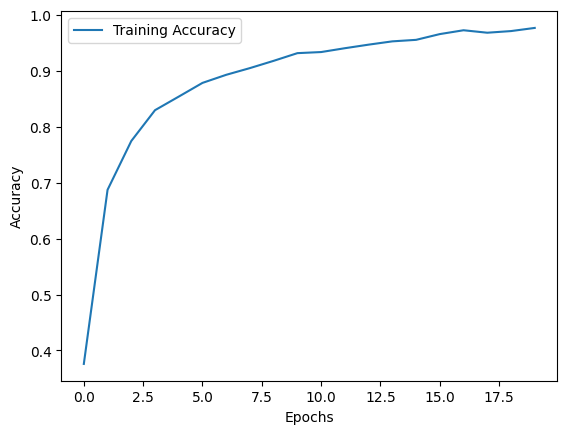

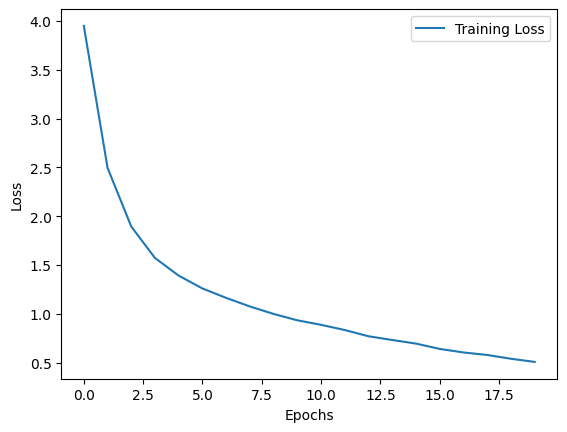

In [ ]:
# Plot accuracy & loss
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()


🔍 Predicting test data for evaluation...
35/35 ━━━━━━━━━━━━━━━━━━━━ 26s 168ms/step

📊 Classification Report:
                 precision    recall  f1-score   support

        Dolphin     0.9286    0.9750    0.9512        80
           Fish     0.7444    0.8375    0.7882        80
     Jelly Fish     0.8605    0.9250    0.8916        80
        Octopus     0.8788    0.7250    0.7945        80
        Penguin     0.9818    0.9000    0.9391       120
       Sea Rays     0.8407    0.7917    0.8155       120
    Sea Urchins     1.0000    0.6250    0.7692        80
       Seahorse     0.9103    0.8875    0.8987        80
         Sharks     0.6634    0.8375    0.7403        80
       Starfish     0.9412    1.0000    0.9697        80
Turtle_Tortoise     0.7723    0.9750    0.8619        80
          Whale     0.8649    0.8000    0.8312        80
           crab     0.9634    0.9875    0.9753        80

       accuracy                         0.8652      1120
      macro avg     0.8731    0.8

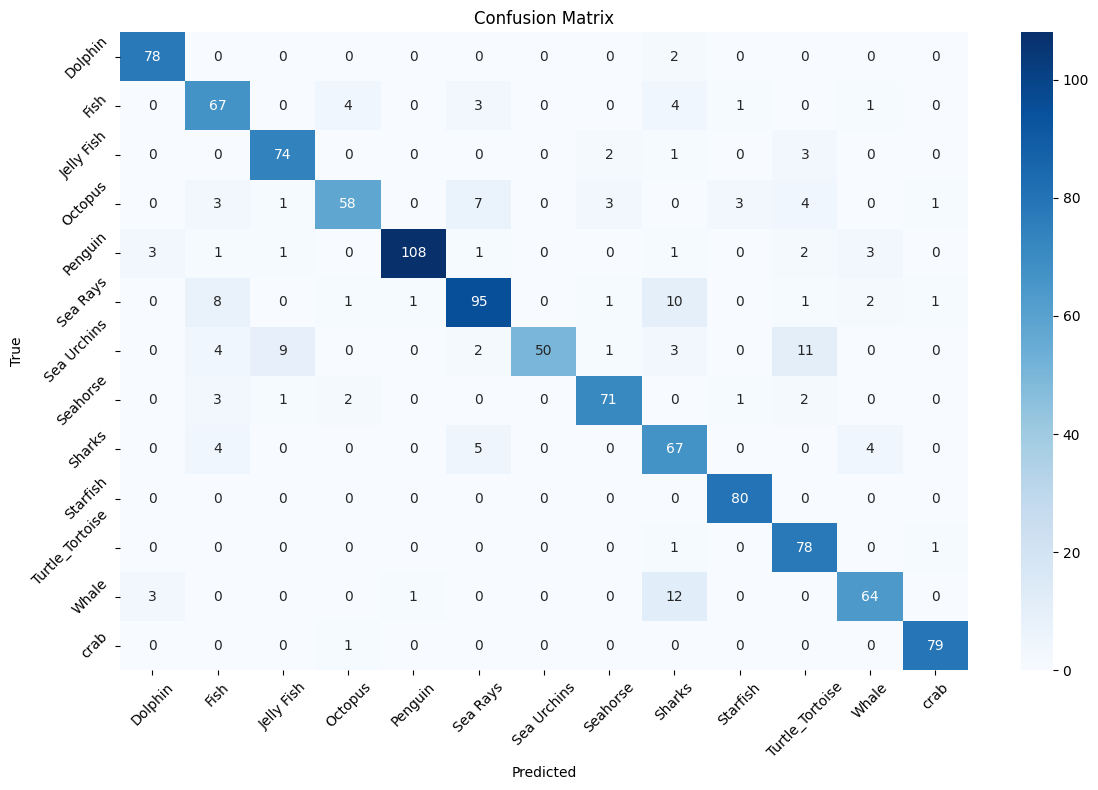

In [ ]:
# Classification Report & Confusion Matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

print("\n🔍 Predicting test data for evaluation...")
y_true = test_data.classes
y_probs = model.predict(test_data)
y_pred = np.argmax(y_probs, axis=1)

print("\n📊 Classification Report:")
report = classification_report(y_true, y_pred, target_names=class_names, digits=4)
print(report)

print("\n📉 Confusion Matrix:")
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(12, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.xticks(rotation=45)
plt.yticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Save model
model.save('/content/drive/MyDrive/DenseNet201_model80.h5')

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import precision_score, recall_score, f1_score
import numpy as np
import os

# === Step 1: Load the trained model ===
model_path = "/content/drive/MyDrive/DenseNet201_model80.h5"
model = load_model(model_path)
print("✅ Model loaded successfully.")

# === Step 2: Set up test data generator ===
image_size = (250, 250) # Changed from (240, 240) to (250, 250) to match model input
batch_size = 32
test_path = '/content/drive/MyDrive/dataset80/80-20/test'

test_datagen = ImageDataGenerator(rescale=1./255)
test_gen = test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)

# === Step 3: Prepare test data and predictions ===
X_test, y_test = [], []
for i in range(len(test_gen)):
    images, labels = test_gen[i]
    X_test.append(images)
    y_test.append(labels)
X_test = np.concatenate(X_test, axis=0)
y_test = np.concatenate(y_test, axis=0).astype(int)

y_pred_probs = model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)

# === Step 4: Compute overall metrics (macro average) ===
precision = precision_score(y_test, y_pred, average='macro')
recall = recall_score(y_test, y_pred, average='macro')
f1 = f1_score(y_test, y_pred, average='macro')

# === Step 5: Print results ===
print("\n📊 Overall Evaluation Metrics (Macro Average):")
print(f"✅ Precision: {precision:.4f}")
print(f"✅ Recall:    {recall:.4f}")
print(f"✅ F1 Score:  {f1:.4f}")

✅ Model loaded successfully.
Found 1120 images belonging to 13 classes.
35/35 ━━━━━━━━━━━━━━━━━━━━ 23s 143ms/step

📊 Overall Evaluation Metrics (Macro Average):
✅ Precision: 0.8351
✅ Recall:    0.8109
✅ F1 Score:  0.8053


In [ ]:
# Save the entire MobileNetV2 model to an HDF5 file
model.save("/content/drive/MyDrive/DenseNet201_model80.h5")

print("Model saved successfully to /content/drive/MyDrive/DenseNet201_model80.h5")

Model saved successfully to /content/drive/MyDrive/DenseNet201_model80.h5


In [ ]:
from tensorflow.keras.models import load_model

# Load the saved EfficientNetV2 model
model = load_model("/content/drive/MyDrive/DenseNet201_model50.h5")

print("Model loaded successfully.")

Model loaded successfully.


In [ ]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

test_path = '/content/drive/MyDrive/dataset50/50-50/test'
image_size = (250, 250)
batch_size = 32

test_datagen = ImageDataGenerator(rescale=1./255)

test_gen = test_datagen.flow_from_directory(
    test_path,
    target_size=image_size,
    batch_size=batch_size,
    class_mode='sparse',
    shuffle=False
)


Found 2600 images belonging to 13 classes.


In [ ]:
class_labels = list(test_gen.class_indices.keys())

1/1 ━━━━━━━━━━━━━━━━━━━━ 22s 22s/step
✅ Predicted Class: Fish


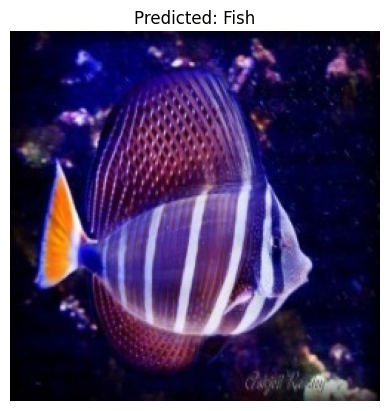

In [ ]:
  from tensorflow.keras.preprocessing import image
  import numpy as np
  import matplotlib.pyplot as plt

  # Get class labels from the test generator
  class_labels = list(test_gen.class_indices.keys())

  # === Function to Predict Single Image ===
  def predict_single_image(img_path, model, class_labels, target_size=(250, 250)): # Changed target_size to 250x250
      # Load and preprocess image
      img = image.load_img(img_path, target_size=target_size)
      img_array = image.img_to_array(img)
      img_array = img_array / 255.0  # Normalize
      img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension

      # Predict
      prediction = model.predict(img_array)
      predicted_class_idx = np.argmax(prediction)
      predicted_class = class_labels[predicted_class_idx]

      # Print and display
      print(f"✅ Predicted Class: {predicted_class}")

      # Optional: Visualize image
      plt.imshow(img)
      plt.title(f"Predicted: {predicted_class}")
      plt.axis('off')
      plt.show()

  # === Example usage ===
  img_path = '/content/drive/MyDrive/dataset80/80-20/train/Fish/10371173425_3f48194c69_b.jpg' # Corrected the string
  predict_single_image(img_path, model, class_labels)

In [ ]:
# Save the entire MobileNetV2 model to an HDF5 file
model.save("/content/drive/MyDrive/DenseNet201_model80.h5")

print("Model saved successfully to /content/drive/MyDrive/DenseNet201_model80.h5")

Model saved successfully to /content/drive/MyDrive/DenseNet201_model80.h5


In [1]:
from google.colab import files

# Replace with your actual path in your Google Drive
file_path = "/content/drive/MyDrive/DenseNet201_model50.h5"

# Download the file
files.download(file_path)


FileNotFoundError: Cannot find file: /content/drive/MyDrive/DenseNet201_model50.h5